In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore")

from datetime import datetime
import json
from tqdm import tqdm
from collections import Counter

In [2]:
pd.set_option('max_columns', 999)

In [3]:
## import dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 1. EDA

## 1.1 Overview of dataset

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

In [6]:
train[['id', 'budget', 'popularity', 'runtime', 'revenue']].describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [7]:
test[['id', 'budget', 'popularity', 'runtime']].describe()

,id,budget,popularity,runtime
count,4398.000000,4.398000e+03,4398.000000,4394.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212
std,1269.737571,3.689991e+07,12.209014,21.058290
min,3001.000000,0.000000e+00,0.000001,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000
50%,5199.500000,7.450000e+06,7.482241,104.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000
max,7398.000000,2.600000e+08,547.488298,320.000000


In [8]:
train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [9]:
test.isnull().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

## 1.2 Features

### 1.2.1 Revenue

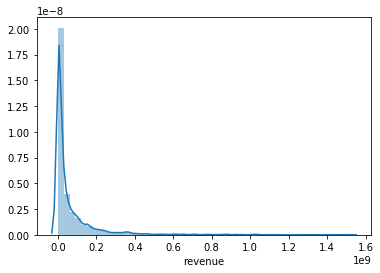

In [10]:
sns.distplot(train.revenue)

In [11]:
## The distribution of revenue is right-skewed

In [12]:
train.revenue.describe()

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64

In [13]:
## Because revenue variable is skewed, we'd like to calculate log of it.
## The log transformation can be used to make highly
## skewed distributions less skewed. 

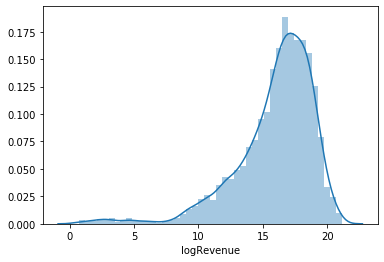

In [14]:
## log(Revenue)'s distribution 
train['logRevenue'] = np.log1p(train['revenue'])
sns.distplot(train.logRevenue)

### 1.2.2 Release Date

In [15]:
list(train.release_date.unique())[:10]

['2/20/15',
 '8/6/04',
 '10/10/14',
 '3/9/12',
 '2/5/09',
 '8/6/87',
 '8/30/12',
 '1/15/04',
 '2/16/96',
 '4/16/03']

In [16]:
train[['release_month', 'release_day','release_year']] = \
    train['release_date'].str.split('/', expand=True).\
    replace(np.nan, -1).astype(int)

train.loc[(train['release_year']<=19)&(train['release_year']<100),'release_year']+=2000
train.loc[(train['release_year']>19)&(train['release_year']<100),'release_year']+=1900

releaseDate = pd.to_datetime(train['release_date'])

train['release_dayofweek'] = releaseDate.dt.dayofweek
train['release_quarter'] = releaseDate.dt.quarter
train['year_from_now'] = 2019-train['release_year']

In [17]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,logRevenue,release_month,release_day,release_year,release_dayofweek,release_quarter,year_from_now
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,16.326300,2,20,2015,4,1,4
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,18.370959,8,6,2004,4,3,15
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,16.387512,10,10,2014,4,4,5
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,16.588099,3,9,2012,4,1,7
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,15.182615,2,5,2009,3,1,10


### 1.2.3 Number of Movies released by date

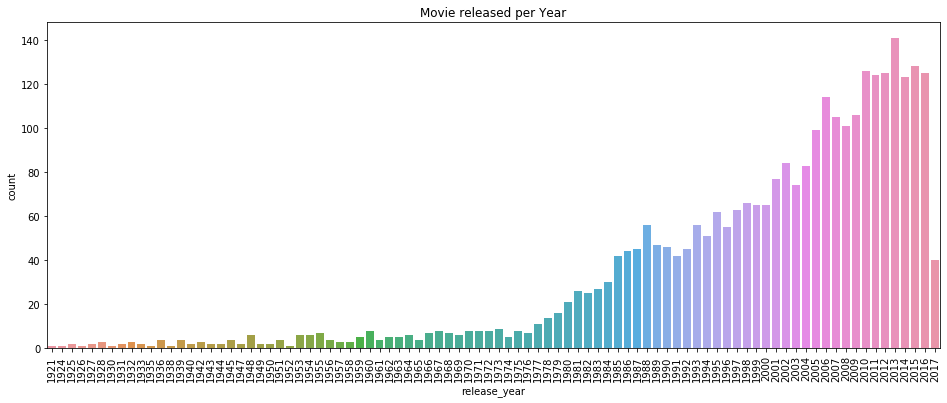

In [18]:
# Plot moive number per year
plt.figure(figsize=(16,6))
sns.countplot(train['release_year'].sort_values())
plt.title('Movie released per Year')
plt.xticks(fontsize=10, rotation=90)
plt.show()

In [19]:
## There are more movies produced with the the year's increase

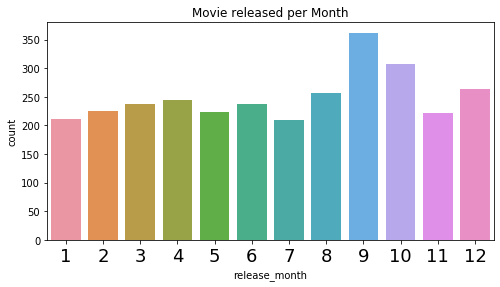

In [20]:
# Plot moive number per month
plt.figure(figsize=(8,4))
sns.countplot(train['release_month'].sort_values())
plt.title('Movie released per Month')
plt.xticks(fontsize=18)
plt.show()

In [21]:
## More movies released in September than other months in train dataset

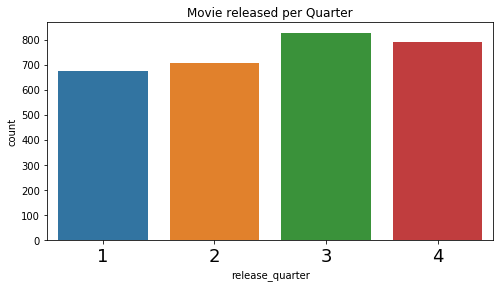

In [22]:
# Plot moive number per quarter
plt.figure(figsize=(8,4))
sns.countplot(train['release_quarter'].sort_values())
plt.title('Movie released per Quarter')
plt.xticks(fontsize=18)
plt.show()

In [23]:
## More movies released in third quarter than other
## months in train dataset

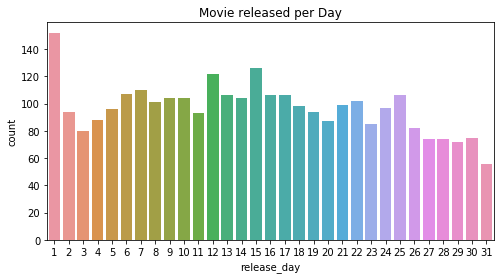

In [24]:
# Plot moive number per Day
plt.figure(figsize=(8,4))
sns.countplot(train['release_day'].sort_values())
plt.title('Movie released per Day')
plt.xticks(fontsize=10)
plt.show()

In [25]:
## More movies are released on the first day of 
##month than other days in train dataset

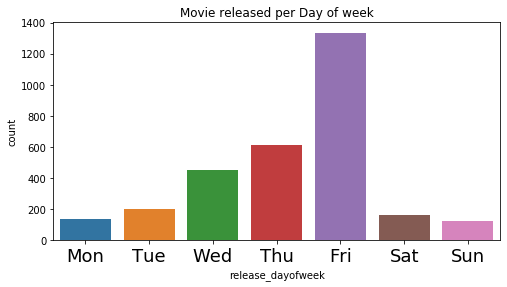

In [26]:
# Plot moive number per Day of week
plt.figure(figsize=(8,4))
sns.countplot(train['release_dayofweek'].sort_values())
plt.title('Movie released per Day of week')
loc, labels = plt.xticks()
loc, labels = loc, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri','Sat','Sun']
plt.xticks(loc, labels, fontsize=18)
plt.show()

In [27]:
## More movies are released on the Friday than other weekdays in train dataset

### 1.2.4 Movie Revenue by date

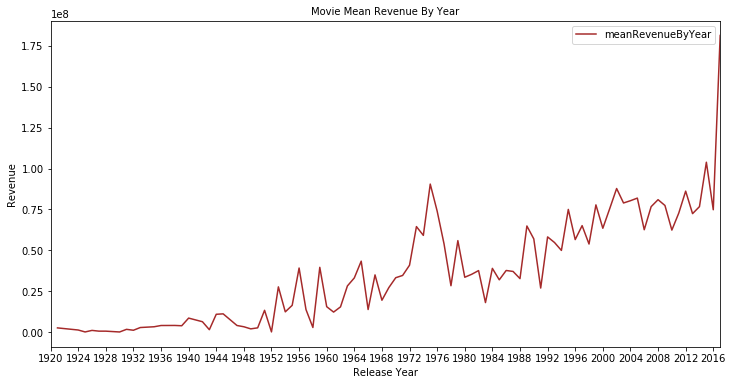

In [28]:
## Plot release year vs revenue
meanRevenueByYear = pd.DataFrame(train.groupby('release_year')['revenue'].aggregate('mean'))
meanRevenueByYear.columns = ['meanRevenueByYear']
# train = pd.merge(train, meanRevenueByYear, how = 'left', left_on='release_year', right_index=True)

meanRevenueByYear.plot(figsize=(12,6),color="brown")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year",fontsize=10)
plt.show()

In [29]:
## The revenue is increasing with the increase of year.

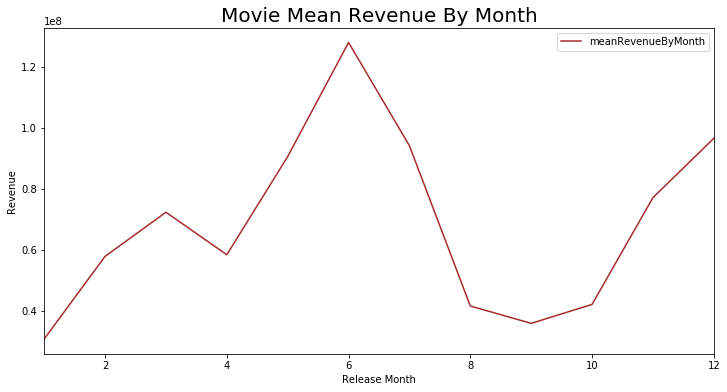

In [30]:

meanRevenueByMonth = pd.DataFrame(train.groupby('release_month')['revenue'].aggregate('mean'))
meanRevenueByMonth.columns = ['meanRevenueByMonth']
# train = pd.merge(train, meanRevenueByMonth, how = 'left', left_on='release_month', right_index=True)

meanRevenueByMonth.plot(figsize=(12,6),color="brown")
plt.xlabel("Release Month")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Month",fontsize=20)
plt.show()

In [31]:
## Movie mean revenue is highest in June.

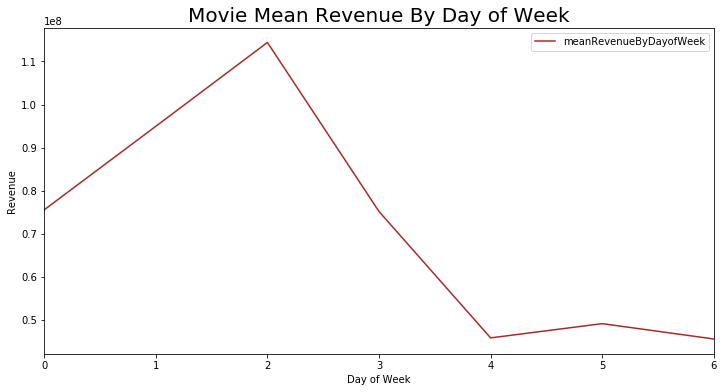

In [32]:
meanRevenueByDayofWeek = pd.DataFrame(train.groupby('release_dayofweek')['revenue'].aggregate('mean'))
meanRevenueByDayofWeek.columns = ['meanRevenueByDayofWeek']

meanRevenueByDayofWeek.plot(figsize=(12,6),color="brown")
plt.xlabel("Day of Week")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Day of Week",fontsize=20)
plt.show()

In [33]:
## Movie mean revenue is highest on Wednesday.

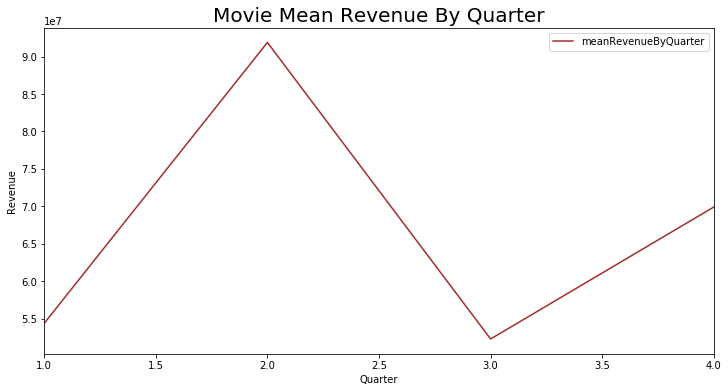

In [34]:
meanRevenueByQuarter = pd.DataFrame(train.groupby('release_quarter')['revenue'].aggregate('mean'))
meanRevenueByQuarter.columns = ['meanRevenueByQuarter']

meanRevenueByQuarter.plot(figsize=(12,6),color="brown")
plt.xlabel("Quarter")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Quarter",fontsize=20)
plt.show()

In [35]:
## The mean revenue of movies in the second quarter is higher than others.

### 1.2.5 Movie Runtime by date

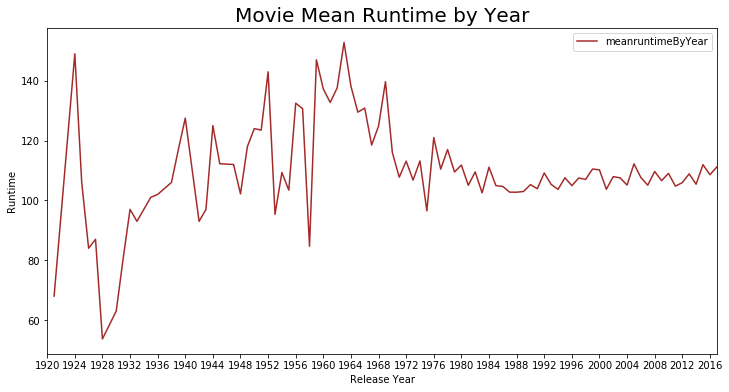

In [36]:
meanruntimeByYear = pd.DataFrame(train.groupby("release_year")["runtime"].aggregate('mean'))
meanruntimeByYear.columns = ['meanruntimeByYear']
train = pd.merge(train, meanruntimeByYear, how = 'left', left_on='release_year', right_index=True)

meanruntimeByYear.plot(figsize=(12,6),color="brown")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Runtime")
plt.title("Movie Mean Runtime by Year",fontsize=20)
plt.show()

In [37]:
## The mean runtime of movies are higher in 1940-1972, and after that, there is no clear 
## change in the average runtime 

### 1.2.6 Movie Popularity by date

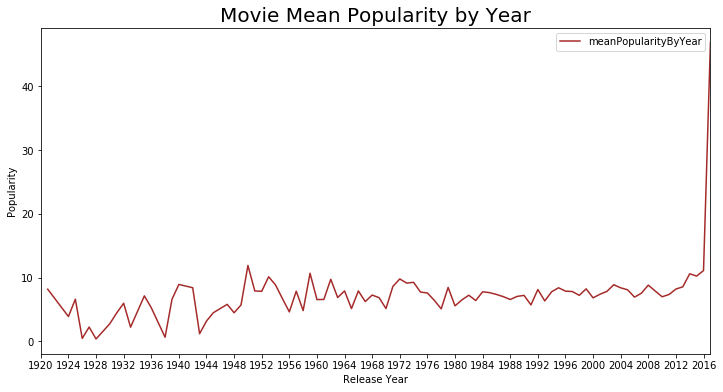

In [38]:
meanPopularityByYear = pd.DataFrame(train.groupby("release_year")["popularity"].aggregate('mean'))
meanPopularityByYear.columns = ['meanPopularityByYear']
train = pd.merge(train, meanPopularityByYear, how = 'left', left_on='release_year', right_index=True)

meanPopularityByYear.plot(figsize=(12,6),color="brown")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Popularity")
plt.title("Movie Mean Popularity by Year",fontsize=20)
plt.show()

In [39]:
## The mean popularity of movies didn't change a lot during thesse years

### 1.2.7 Movie Budget by date

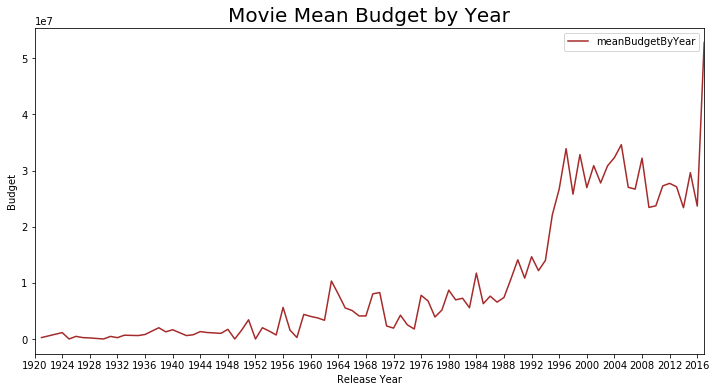

In [40]:
meanBudgetByYear = pd.DataFrame(train.groupby("release_year")["budget"].aggregate('mean'))
meanBudgetByYear.columns = ['meanBudgetByYear']
train = pd.merge(train, meanBudgetByYear, how = 'left', left_on='release_year', right_index=True)

meanBudgetByYear.plot(figsize=(12,6),color="brown")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Budget")
plt.title("Movie Mean Budget by Year",fontsize=20)
plt.show()

In [41]:
## Mean budget of movies shows a upward trend over thes years

### 1.2.8 Log(Budget)

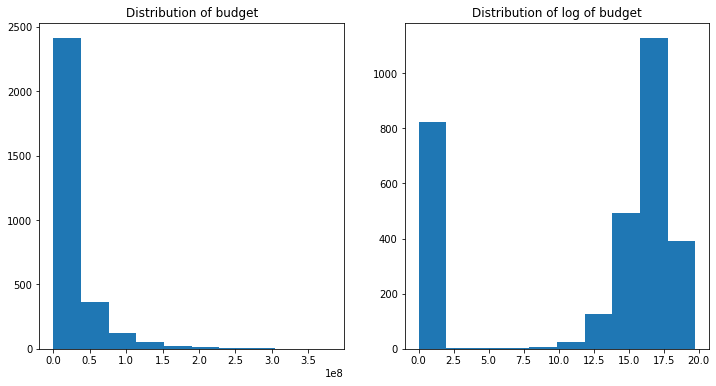

In [42]:
## log(Budget)
fig, ax = plt.subplots(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

In [43]:
## log(Budget) is less skewed

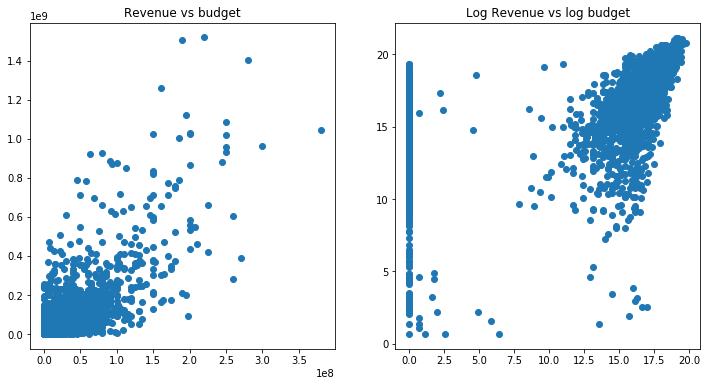

In [44]:
## log(Budget) vs. log(Revenue)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), np.log1p(train['revenue']))
plt.title('Log Revenue vs log budget');

In [45]:
## There is truly some relationship between the log(revenue) and the log(budget)

### Data extration for some text features

In [46]:
train.shape, test.shape

((3000, 33), (4398, 22))

In [47]:
cols = ['belongs_to_collection', 'Keywords','genres', 'cast', 'crew', \
        'production_countries','production_companies']

def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d
    
for col in cols:
    train[col] = train[col].apply(get_dictionary)
    test[col] = test[col].apply(get_dictionary)
    
## Store all these data into a dict  ['Keywords', 'cast', 'crew'] 
content_dict = {}
for col in cols:
    l = []
    for row in train[col]:
        for i in range(len(row)):
            try:   ### do not drop duplicate in order to find the most common
                l.append(row[i]['name'])
            except:
                None
        if col == 'genres':
                most_common = [i[0] for i in Counter(l).most_common(20)]
        else:
            most_common = [i[0] for i in Counter(l).most_common(10)]
            content_dict[col] = most_common
    content_dict[col] = most_common

def get_dummies(data):
    for col in tqdm(cols):
        for feature in content_dict[col]:
            data[col+'_'+feature] = data[col].apply(lambda x: 1 if feature in [d['name'] for d in x] else 0)
    return data

train = get_dummies(train)
test = get_dummies(test)

100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


In [48]:
train.shape, test.shape

((3000, 113), (4398, 102))

### 1.2.9 Genre

In [49]:
## train
genres_col = ['genres_'+ i for i in content_dict['genres']]
train[genres_col].sum(axis=0)

genres_Drama              1531
genres_Comedy             1028
genres_Thriller            789
genres_Action              741
genres_Romance             571
genres_Crime               469
genres_Adventure           439
genres_Horror              301
genres_Science Fiction     290
genres_Family              260
genres_Fantasy             232
genres_Mystery             225
genres_Animation           141
genres_History             132
genres_Music               100
genres_War                 100
genres_Documentary          87
genres_Western              43
genres_Foreign              31
genres_TV Movie              1
dtype: int64

In [50]:
## test
genres_col = ['genres_'+ i for i in content_dict['genres']]
test[genres_col].sum(axis=0)

genres_Drama              2145
genres_Comedy             1577
genres_Thriller           1080
genres_Action              994
genres_Romance             864
genres_Crime               615
genres_Adventure           677
genres_Horror              434
genres_Science Fiction     454
genres_Family              415
genres_Fantasy             396
genres_Mystery             325
genres_Animation           241
genres_History             163
genres_Music               167
genres_War                 143
genres_Documentary         134
genres_Western              74
genres_Foreign              53
genres_TV Movie              0
dtype: int64

### 1.2.10 Original Language

In [51]:
train['original_language'].value_counts()[:10]

en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
ko      20
cn      20
zh      19
Name: original_language, dtype: int64

In [52]:
## Most Movies' original language is English

In [53]:
revenuebylanguage = pd.DataFrame(train.groupby('original_language')['revenue'].agg(['mean','count'])
                                 .sort_values(by = 'mean',ascending=False))
revenuebylanguage.head(10)

,mean,count
original_language,,
en,7.466591e+07,2575
zh,7.037637e+07,19
tr,5.166341e+07,3
ja,3.065180e+07,37
cn,2.977289e+07,20
hi,2.534637e+07,42
de,2.053090e+07,18
fr,1.713257e+07,78
it,1.641513e+07,24


In [54]:
## The mean revenue of English movies are higher than movies with other languages

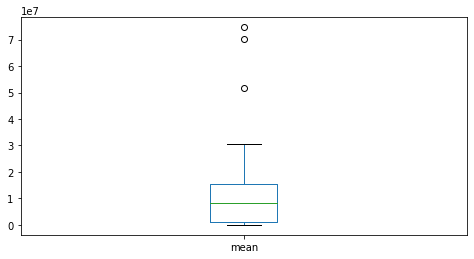

In [55]:
plt.figure(figsize=(8,4))
# sns.catplot(x='original_language', y ='mean', data = revenuebylanguage, kind='bar' )
revenuebylanguage['mean'].plot(kind='box')

In [56]:
## The mean revenues of English movies are centralized

<Figure size 864x432 with 0 Axes>

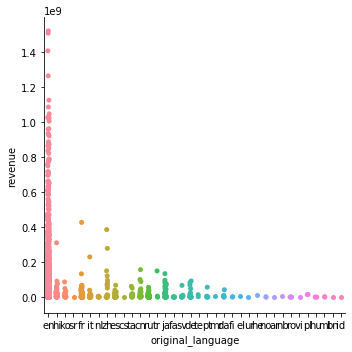

In [57]:
plt.figure(figsize=(12,6))
sns.catplot(x='original_language', y ='revenue', data = train)
plt.show()

In [58]:
### English is the most common Original language.

### 1.2.11 homepage

In [59]:
train['homepage'].value_counts()[:10]

http://www.transformersmovie.com/                           4
http://www.lordoftherings.net/                              2
http://www.thehobbit.com/                                   2
http://www.downfallthefilm.com/                             1
http://www.thegreatestmovieeversold.com/                    1
http://www.mgm.com/#/our-titles/366/Cherry-2000             1
http://www.hiddenfigures.com                                1
http://www.indianajones.com                                 1
http://neueroadmovies.com/film/every-thing-will-be-fine/    1
http://www.mangafilms.es/pagafantas/                        1
Name: homepage, dtype: int64

In [60]:
len(train['homepage'])

3000

In [61]:
train['homepage'].isnull().sum()

2054

In [62]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1

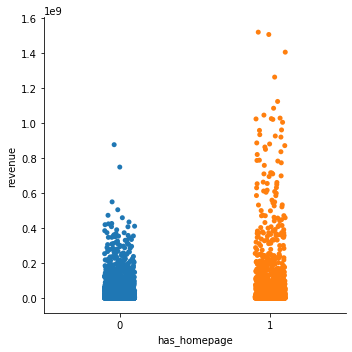

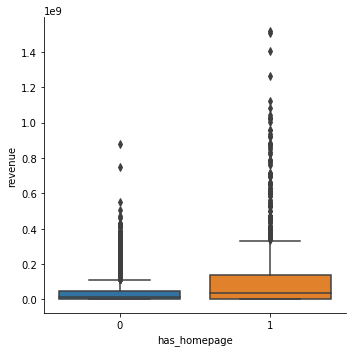

In [63]:
sns.catplot(x ='has_homepage', y='revenue', data = train)
sns.catplot(x ='has_homepage', y='revenue', data = train, kind='box')

In [64]:
### Movies has homepage tend to have more revenue

### 1.2.12 original_title and title

In [65]:
train[['original_title', 'title']][:10]

,original_title,title
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement
2,Whiplash,Whiplash
3,Kahaani,Kahaani
4,마린보이,Marine Boy
5,Pinocchio and the Emperor of the Night,Pinocchio and the Emperor of the Night
6,The Possession,The Possession
7,Control Room,Control Room
8,Muppet Treasure Island,Muppet Treasure Island
9,A Mighty Wind,A Mighty Wind


In [66]:
train['title_is_originaltitle'] = 0
train.loc[train['original_title'] == train['title'], 'title_is_originaltitle'] = 1

In [67]:
train['title_is_originaltitle'].sum()

2649

In [68]:
train[['original_title', 'title', 'title_is_originaltitle']][:10]

,original_title,title,title_is_originaltitle
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,1
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,1
2,Whiplash,Whiplash,1
3,Kahaani,Kahaani,1
4,마린보이,Marine Boy,0
5,Pinocchio and the Emperor of the Night,Pinocchio and the Emperor of the Night,1
6,The Possession,The Possession,1
7,Control Room,Control Room,1
8,Muppet Treasure Island,Muppet Treasure Island,1
9,A Mighty Wind,A Mighty Wind,1


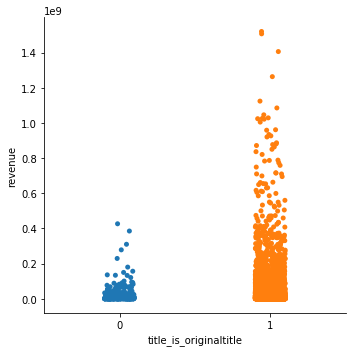

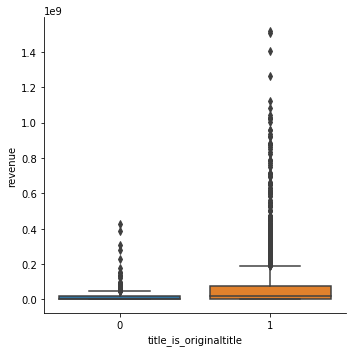

In [69]:
sns.catplot(x ='title_is_originaltitle', y='revenue', data = train)
sns.catplot(x ='title_is_originaltitle', y='revenue', data = train, kind='box')

In [70]:
## The film with original title has much more revenue. 

### 1.2.13 overview

In [71]:
train['overview'][:10]

0    When Lou, who has become the "father of the In...
1    Mia Thermopolis is now a college graduate and ...
2    Under the direction of a ruthless instructor, ...
3    Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
4    Marine Boy is the story of a former national s...
5    Pinocchio and his friends, a glow worm and a m...
6    A young girl buys an antique box at a yard sal...
7    A chronicle which provides a rare window into ...
8    After telling the story of Flint's last journe...
9    In "A Mighty Wind", director Christopher Guest...
Name: overview, dtype: object

### 1.2.14 popularity

In [72]:
train['popularity'][:10]

0     6.575393
1     8.248895
2    64.299990
3     3.174936
4     1.148070
5     0.743274
6     7.286477
7     1.949044
8     6.902423
9     4.672036
Name: popularity, dtype: float64

In [73]:
train['popularity'].isnull().sum()

0

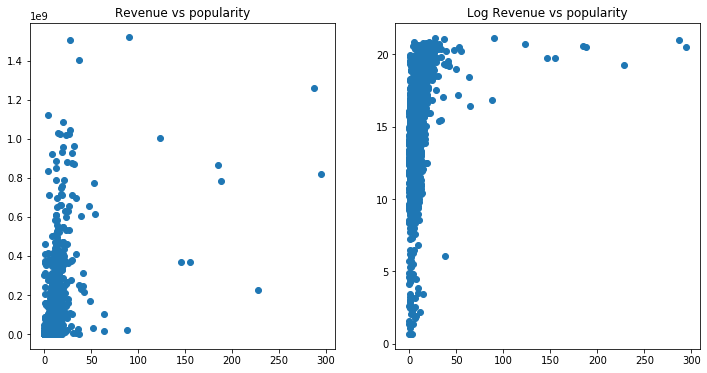

In [74]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity');
plt.subplot(1, 2, 2)
plt.scatter(train['popularity'], train['logRevenue'])
plt.title('Log Revenue vs popularity');

In [75]:
train['Popularity_ratio']= train['popularity']/train['meanPopularityByYear']

In [76]:
## The log(Revenue) seems to have positive relationship with popularity

### 1.2.15 runtime

In [77]:
train['runtime'][:10]

0     93.0
1    113.0
2    105.0
3    122.0
4    118.0
5     83.0
6     92.0
7     84.0
8    100.0
9     91.0
Name: runtime, dtype: float64

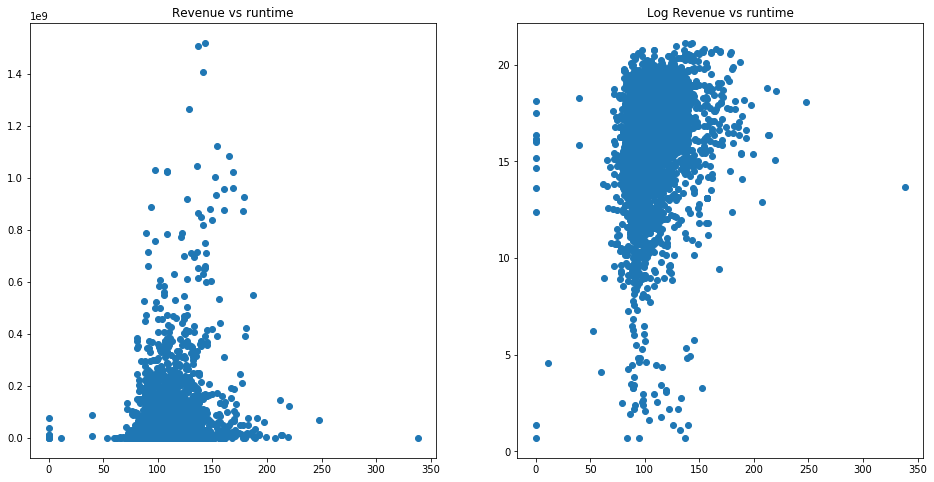

In [78]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['runtime'], train['revenue'])
plt.title('Revenue vs runtime');
plt.subplot(1, 2, 2)
plt.scatter(train['runtime'], train['logRevenue'],)
plt.title('Log Revenue vs runtime');


In [79]:
train['run_time_ratio'] = train['runtime'] / train['meanruntimeByYear']

In [80]:
## For most films with the length of 75-150 minutes, the revenue is most likely higher.

### 1.2.16 status

In [81]:
train['status'][:10]

0    Released
1    Released
2    Released
3    Released
4    Released
5    Released
6    Released
7    Released
8    Released
9    Released
Name: status, dtype: object

In [82]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [83]:
2996 / 3000

0.9986666666666667

In [84]:
test['status'].value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

In [85]:
4389 / len(test)

0.9979536152796725

In [86]:
## 99.80% of all the movies are released.

### 1.2.17 tagline

In [87]:
train['tagline'][:10]

0    The Laws of Space and Time are About to be Vio...
1    It can take a lifetime to find true love; she'...
2      The road to greatness can take you to the edge.
3                                                  NaN
4                                                  NaN
5                                                  NaN
6                 Fear The Demon That Doesn't Fear God
7                Different channels. Different truths.
8                          Set sail for Muppet mayhem!
9             Back together for the first time, again.
Name: tagline, dtype: object

In [88]:
train['tagline'].isnull().sum()

597

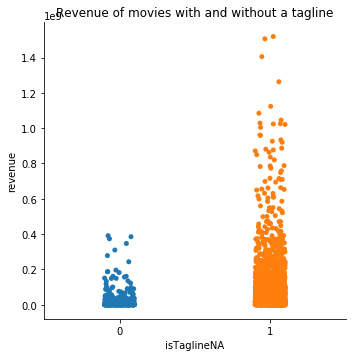

In [89]:
# # Train
train['isTaglineNA'] = 0
train.loc[train['tagline'].isnull() == False ,'isTaglineNA'] = 1

# Test
test['isTaglineNA'] = 0
test.loc[test['tagline'].isnull() == False,'isTaglineNA'] = 1

sns.catplot(x="isTaglineNA", y="revenue", data=train)
plt.title('Revenue of movies with and without a tagline');

In [90]:
## Movies with a tagline have more revenue. 

In [91]:
train.iloc[:,:40].isnull().sum()

id                                                                 0
belongs_to_collection                                              0
budget                                                             0
genres                                                             0
homepage                                                        2054
imdb_id                                                            0
original_language                                                  0
original_title                                                     0
overview                                                           8
popularity                                                         0
poster_path                                                        1
production_companies                                               0
production_countries                                               0
release_date                                                       0
runtime                           

### 1.2.18 Cast count

In [92]:
train['cast_count'] = train['cast'].apply(lambda x: len(x))

train['cast_count'][:10]

0    24
1    20
2    51
3     7
4     4
5     4
6    14
7     4
8    12
9    20
Name: cast_count, dtype: int64

### 1.2.19 Crew count

In [93]:
train['crew_count'] = train['crew'].apply(lambda x: len(x))

train['crew_count'][:10]

0    72
1     9
2    64
3     3
4     2
5    11
6    77
7     1
8     8
9    11
Name: crew_count, dtype: int64

### 1.2.20 genres count

In [94]:
train['genres_count'] = train['genres'].apply(lambda x: len(x))

train['genres_count'][:10]

0    1
1    4
2    1
3    2
4    2
5    3
6    2
7    1
8    5
9    2
Name: genres_count, dtype: int64

### 1.2.21 production company count

In [95]:
train['production_countries_count'] = train['production_countries'].apply(lambda x: len(x))

train['production_countries_count']

0       1
1       1
2       1
3       1
4       1
       ..
2995    1
2996    2
2997    1
2998    1
2999    1
Name: production_countries_count, Length: 3000, dtype: int64

In [96]:
train['production_countries_count'].value_counts()

1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries_count, dtype: int64

In [97]:
## Most of movies in the train dataset has one or two production companies

## 1.3 Additional data

In [98]:
ad_train = pd.read_csv('TrainAdditionalFeatures.csv')
ad_train.head()
ad_test = pd.read_csv('TestAdditionalFeatures.csv')
ad_test.head()

,imdb_id,popularity2,rating,totalVotes
0,tt0113101,11.182,6.3,1078.0
1,tt0107286,8.038,6.5,111.0
2,tt0076759,36.016,8.2,10729.0
3,tt0266543,18.503,7.8,10766.0
4,tt0033467,15.322,8.1,2203.0


In [99]:
train = pd.merge(train, ad_train[['imdb_id','rating', 'totalVotes']] , how='left', on='imdb_id')
test = pd.merge(test, ad_test[['imdb_id','rating', 'totalVotes']] , how='left', on='imdb_id')

### 1.3.1 Rating

In [100]:
rating_by_year = pd.DataFrame(train.groupby('release_year')['rating'].median())
rating_by_year.columns =['rating_by_year']

In [101]:
train = pd.merge(train, rating_by_year, how='left', left_on='release_year', right_index=True)

In [102]:
def fill_rating(df):
    if pd.isnull(df['rating']) == True:
        df['rating'] = df['rating_by_year']
    return df
train = train.apply(fill_rating, axis=1)

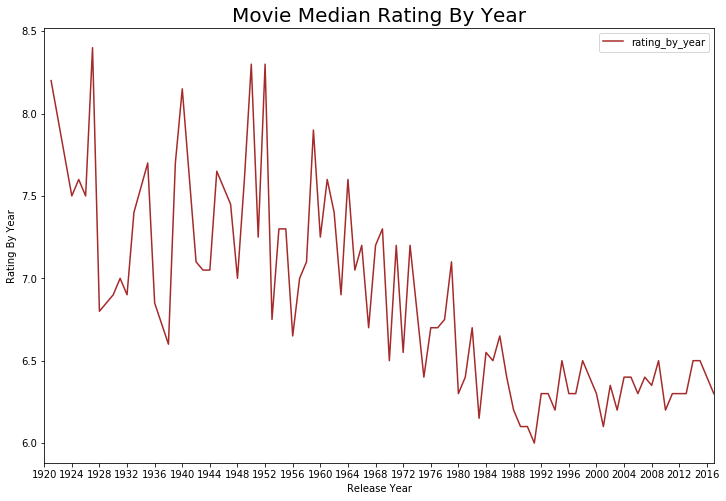

In [103]:
rating_by_year.plot(figsize=(12,8),color="brown")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Rating By Year")
plt.title("Movie Median Rating By Year",fontsize=20)
plt.show()

In [104]:
## Movie median rating went down through these years

### 1.3.2 Voting

In [105]:
voting_by_year = pd.DataFrame(train.groupby('release_year')['totalVotes'].median())
voting_by_year.columns =['voting_by_year']

In [106]:
train = pd.merge(train, voting_by_year, how='left', left_on='release_year', right_index=True)

In [107]:
def fill_voting(df):
    if pd.isnull(df['totalVotes']) == True:
        df['totalVotes'] = df['voting_by_year']
    return df
train = train.apply(fill_voting, axis=1)

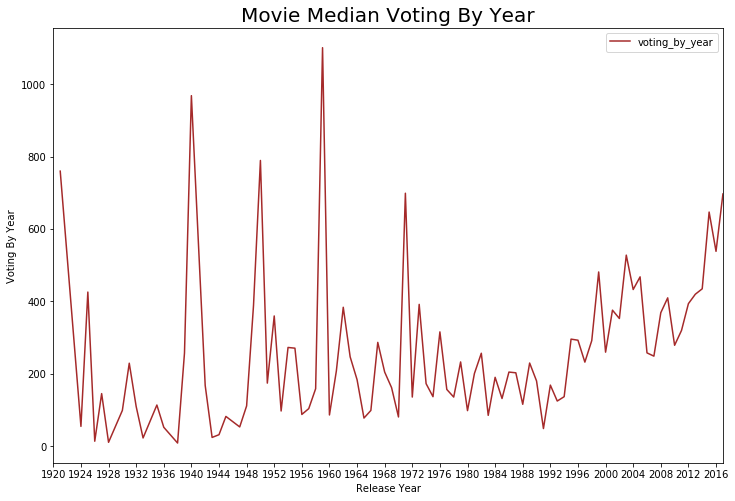

In [108]:
voting_by_year.plot(figsize=(12,8),color="brown")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Voting By Year")
plt.title("Movie Median Voting By Year",fontsize=20)
plt.show()

In [109]:
## There is no clear trend with number of votes in these years

# 2. Feature Engineering

In [110]:
## data extraction for train and test, get dummies for text variables
def data_extration(train):
    cols = ['belongs_to_collection','genres', 'Keywords', 'cast', 'crew', 'production_countries', \
            'production_companies']
#     cols_dict = [i + '_dict' for i in cols]

    def get_dictionary(s):
        try:
            d = eval(s)
        except:
            d = {}
        return d
    
    for col in cols:
        train[col] = train[col].apply(get_dictionary)
   
    ## Store all these data into a dict
    content_dict = {}
    for col in cols:
        l = []
        for row in train[col]:
            for i in range(len(row)):
                try:   ### do not drop duplicate in order to find the most common
                    l.append(row[i]['name'])
                except:
                    None
        if col == 'genres':
            most_common = [i[0] for i in Counter(l).most_common(20)]
        else:
            most_common = [i[0] for i in Counter(l).most_common(15)]
        content_dict[col] = most_common
        
    return content_dict

In [111]:
def get_started(df, content_dict, train_or_test = 'train'):
    cols = ['belongs_to_collection','genres', 'Keywords', 'cast', 'crew', 'production_countries', \
            'production_companies']
    ## Release time
    df[['release_month', 'release_day','release_year']] = df['release_date'].str.split('/', expand=True).replace(np.nan, -1).astype(int)

    df.loc[(df['release_year'] <= 19) & (df['release_year'] < 100), 'release_year'] +=2000
    df.loc[(df['release_year'] >  19) & (df['release_year'] < 100), 'release_year'] +=1900

    releaseDate = pd.to_datetime(df['release_date'])

    df['release_dayofweek'] = releaseDate.dt.dayofweek
    df['release_quarter'] = releaseDate.dt.quarter
    df['year_from_now'] = 2019-df['release_year'] ## since
    
    ## mean runtime time by year and fill 0s with mean runtime of each year
    meanruntimeByYear = pd.DataFrame(df[df.runtime > 0].groupby("release_year")["runtime"].aggregate('mean'))
    meanruntimeByYear.columns = ['meanruntimeByYear']
    df = pd.merge(df, meanruntimeByYear, how = 'left', left_on='release_year', right_index=True)
    df.runtime[df.runtime == 0] = df['meanruntimeByYear']

    ## mean popularity by year
    meanPopularityByYear = pd.DataFrame(df.groupby("release_year")["popularity"].aggregate('mean'))
    meanPopularityByYear.columns = ['meanPopularityByYear']
    df = pd.merge(df, meanPopularityByYear, how = 'left', left_on='release_year', right_index=True)
    
    ## mean budget by year
    meanBudgetByYear = pd.DataFrame(df[df.budget>100].groupby("release_year")["budget"].aggregate('mean'))
    meanBudgetByYear.columns = ['meanBudgetByYear']
    df = pd.merge(df, meanBudgetByYear, how = 'left', left_on='release_year', right_index=True)
    ## fill budget with yearly mean budget
    df.budget[df.budget == 0] = df.meanBudgetByYear
    
    ## is original language english
    def isOriginalEn(data):
        data['isOriginalEn'] = 0
        data.loc[data['original_language'] == 'en', 'isOriginalEn'] = 1
        return data
    df = isOriginalEn(df)
    
    ## has homepage
    df['has_homepage'] = 0
    df.loc[df['homepage'].isnull() == False, 'has_homepage'] = 1
    
    # is title origial title
    df['title_is_originaltitle'] = 0
    df.loc[df['original_title'] == df['title'], 'title_is_originaltitle'] = 1
    
    # popularity ratio
    df['Popularity_ratio']= df['popularity']/df['meanPopularityByYear']

    # run time
    df['run_time_ratio'] = df['runtime'] / df['meanruntimeByYear']
    
    # is tagline nan
    df['isTaglineNA'] = 0
    df.loc[df['tagline'].isnull() == False ,'isTaglineNA'] = 1
    
    # budget and runtime ratio
    df['budget_to_runtime'] = df['budget'] / df['runtime'] 
    
    # budget and popularity ratio
    df['budget_to_popularity'] = df['budget'] / df['popularity']

    # budget year ratio
    df['budget_ratio'] = df['budget'] / df['meanBudgetByYear']
    
    # log(Budget)
    df['log_budget'] = np.log1p(train['budget'])
    
    def get_dictionary(s):
        try:
            d = eval(s)
        except:
            d = {}
        return d
    ## additional data
    if train_or_test == 'train':
        ad = pd.read_csv('trainAdditionalFeatures.csv')
    else:
        ad = pd.read_csv('testAdditionalFeatures.csv')
        for col in cols:
            df[col] = df[col].apply(get_dictionary)
    
    ## merge additional data
    df = pd.merge(df, ad[['imdb_id','rating', 'totalVotes']] , how='left', on='imdb_id')
    
    rating_by_year = pd.DataFrame(df.groupby('release_year')['rating'].median())
    rating_by_year.columns =['rating_by_year']
    df = pd.merge(df, rating_by_year, how='left', left_on='release_year', right_index=True)
    
    def fill_rating(df):
        if pd.isnull(df['rating']) == True:
            df['rating'] = df['rating_by_year']
        return df
    df = df.apply(fill_rating, axis=1)
    
    voting_by_year = pd.DataFrame(df.groupby('release_year')['totalVotes'].median())
    voting_by_year.columns =['voting_by_year']
    df = pd.merge(df, voting_by_year, how='left', left_on='release_year', right_index=True)
    def fill_voting(df):
        if pd.isnull(df['totalVotes']) == True:
            df['totalVotes'] = df['voting_by_year']
        return df
    df = df.apply(fill_voting, axis=1)
    
    ## ================================================================================================
    
    cols = ['belongs_to_collection', 'Keywords','genres', 'cast', 'crew', \
        'production_countries','production_companies']

    
    def get_dummies(data):
        for col in tqdm(cols):
            for feature in content_dict[col]:
                data[col+'_'+feature] = data[col].apply(lambda x: 1 if feature in [d['name'] for d in x] else 0)
        return data
        
    df = get_dummies(df)
    
    df['cast_count'] = df['cast'].apply(lambda x: len(x))
    df['crew_count'] = df['crew'].apply(lambda x: len(x))
    df['genres_count'] = df['genres'].apply(lambda x: len(x))
    df['production_countries_count'] = df['production_countries'].apply(lambda x: len(x))

    columns_to_drop = ['release_year','belongs_to_collection','id', 'genres', 'homepage','imdb_id',\
                       'original_language', 'original_title', 'overview','poster_path', 'production_companies', \
                       'production_countries', 'release_date', 'spoken_languages','status',\
                       'tagline', 'title', 'Keywords', 'cast', 'crew']
    df = df.drop(columns_to_drop, axis=1)
    return df

In [112]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [113]:
## data cleaning
## train dataset cleaning, fill data with coordinate budgets and revenues
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

## test dataset cleaning
test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

In [114]:
content_dict = data_extration(train)
train = get_started(train, content_dict)

100%|██████████| 7/7 [00:00<00:00, 16.41it/s]


In [115]:
test = get_started(test, content_dict,'test')

100%|██████████| 7/7 [00:00<00:00, 10.16it/s]


In [116]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4398 entries, 0 to 4397
Columns: 139 entries, budget to production_countries_count
dtypes: float64(18), int64(121)
memory usage: 4.7 MB


In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Columns: 140 entries, budget to production_countries_count
dtypes: float64(16), int64(124)
memory usage: 3.3 MB


In [118]:
## remove missing values for model building
train = train.dropna()

In [119]:
train.shape

(2994, 140)

# 3.Modeling

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.metrics import mean_squared_log_error
import math

In [121]:
train.columns

Index(['budget', 'popularity', 'runtime', 'revenue', 'release_month',
       'release_day', 'release_dayofweek', 'release_quarter', 'year_from_now',
       'meanruntimeByYear',
       ...
       'production_companies_Columbia Pictures Corporation',
       'production_companies_TriStar Pictures',
       'production_companies_Relativity Media', 'production_companies_Canal+',
       'production_companies_United Artists',
       'production_companies_Miramax Films', 'cast_count', 'crew_count',
       'genres_count', 'production_countries_count'],
      dtype='object', length=140)

## 3.1 Data Spliting

In [122]:
X = train.drop(['revenue'], axis=1)
Y = np.log1p(train['revenue'])

In [123]:
# Y's type
from sklearn.utils.multiclass import type_of_target
type_of_target(Y)

'continuous'

In [124]:
# separate X and Y to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2,
                                                random_state = 1)

In [125]:
X_train[X_train.index == 935]

,budget,popularity,runtime,release_month,release_day,release_dayofweek,release_quarter,year_from_now,meanruntimeByYear,meanPopularityByYear,meanBudgetByYear,isOriginalEn,has_homepage,title_is_originaltitle,Popularity_ratio,run_time_ratio,isTaglineNA,budget_to_runtime,budget_to_popularity,budget_ratio,log_budget,rating,totalVotes,rating_by_year,voting_by_year,belongs_to_collection_James Bond Collection,belongs_to_collection_Friday the 13th Collection,belongs_to_collection_The Pink Panther (Original) Collection,belongs_to_collection_Police Academy Collection,belongs_to_collection_Pokémon Collection,belongs_to_collection_Rocky Collection,belongs_to_collection_Ice Age Collection,belongs_to_collection_The Fast and the Furious Collection,belongs_to_collection_Rambo Collection,belongs_to_collection_Alien Collection,belongs_to_collection_Resident Evil Collection,belongs_to_collection_Child's Play Collection,belongs_to_collection_Transformers Collection,belongs_to_collection_Paranormal Activity Collection,belongs_to_collection_Rush Hour Collection,Keywords_woman director,Keywords_independent film,Keywords_duringcreditsstinger,Keywords_murder,Keywords_based on novel,Keywords_violence,Keywords_sport,Keywords_biography,Keywords_aftercreditsstinger,Keywords_dystopia,Keywords_revenge,Keywords_friendship,Keywords_sex,Keywords_suspense,Keywords_sequel,genres_Drama,genres_Comedy,genres_Thriller,genres_Action,genres_Romance,genres_Crime,genres_Adventure,genres_Horror,genres_Science Fiction,genres_Family,genres_Fantasy,genres_Mystery,genres_Animation,genres_History,genres_Music,genres_War,genres_Documentary,genres_Western,genres_Foreign,genres_TV Movie,cast_Samuel L. Jackson,cast_Robert De Niro,cast_Morgan Freeman,cast_J.K. Simmons,cast_Bruce Willis,cast_Liam Neeson,cast_Susan Sarandon,cast_Bruce McGill,cast_John Turturro,cast_Forest Whitaker,cast_Willem Dafoe,cast_Bill Murray,cast_Owen Wilson,cast_Nicolas Cage,cast_Sylvester Stallone,crew_Avy Kaufman,crew_Robert Rodriguez,crew_Deborah Aquila,crew_James Newton Howard,crew_Mary Vernieu,crew_Steven Spielberg,crew_Luc Besson,crew_Jerry Goldsmith,crew_Francine Maisler,crew_Tricia Wood,crew_James Horner,crew_Kerry Barden,crew_Bob Weinstein,crew_Harvey Weinstein,crew_Janet Hirshenson,production_countries_United States of America,production_countries_United Kingdom,production_countries_France,production_countries_Germany,production_countries_Canada,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Australia,production_countries_Russia,production_countries_Spain,production_countries_China,production_countries_Hong Kong,production_countries_Ireland,production_countries_Belgium,production_companies_Warner Bros.,production_companies_Universal Pictures,production_companies_Paramount Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Columbia Pictures,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Touchstone Pictures,production_companies_Walt Disney Pictures,production_companies_Columbia Pictures Corporation,production_companies_TriStar Pictures,production_companies_Relativity Media,production_companies_Canal+,production_companies_United Artists,production_companies_Miramax Films,cast_count,crew_count,genres_count,production_countries_count
935,1.283913e+07,6.816276,93.0,5,8,4,2,32,102.755556,6.999629,1.283913e+07,1,0,1,0.973805,0.905061,1,138055.165965,1.883599e+06,1.0,0.0,6.4,32.0,6.4,203.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,3,1,2


In [126]:
X_train.shape

(2395, 139)

In [127]:
X_test.shape

(599, 139)

In [128]:
Y_train.shape

(2395,)

In [129]:
Y_test.shape

(599,)

## 3.2 Models

### 3.2.1 XGBoost

In [130]:
### parameters selection
param_grid = dict(n_estimators = range(100, 500, 40),learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2],
             max_depth = [2,3,4], subsample = [0.6,0.8], colsample_bytree = [0.6,0.8])

movie_XGB = XGBRegressor(random_state=1)
grid_search = GridSearchCV(movie_XGB, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs = -1)
grid_result = grid_search.fit(X_train, Y_train)

print('best_params: ', grid_result.best_params_)

[00:17:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best_params:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 220, 'subsample': 0.8}


In [131]:
## fit model using best_params
eval_set = [(X_test,Y_test)]
movie_best_XGB = XGBRegressor(learning_rate=0.05, max_depth=3, n_estimators=240, random_state=1,\
                             subsample = 0.7, colsample_bytree = 0.6)
movie_best_XGB.fit(X_train,Y_train, early_stopping_rounds = 10,
         eval_metric ='rmse',
         eval_set = eval_set,verbose = False)

## predict
Y_pred = movie_best_XGB.predict(X_test)
mean_squared_error(Y_test,Y_pred)**(1/2)

[00:17:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


1.8612715398713022

In [132]:
### rmsle
Y_test1 = np.expm1(Y_test)
Y_pred1 = np.expm1(Y_pred)
np.sqrt(mean_squared_log_error(Y_test1, Y_pred1))

1.8612715398713022

In [133]:
importance_XGB = movie_best_XGB.feature_importances_
## look into the importance of every feature
importances_XGB = pd.DataFrame({'Importance':importance_XGB},index = X.columns)
thresholds_XGB = importances_XGB.sort_values(by='Importance',axis = 0, ascending = False)
thresholds_XGB[:15]

,Importance
log_budget,0.157449
isTaglineNA,0.072282
budget_ratio,0.061209
totalVotes,0.057941
Popularity_ratio,0.057786
budget_to_runtime,0.051855
budget,0.042057
budget_to_popularity,0.040763
year_from_now,0.024003
cast_Bruce McGill,0.017740


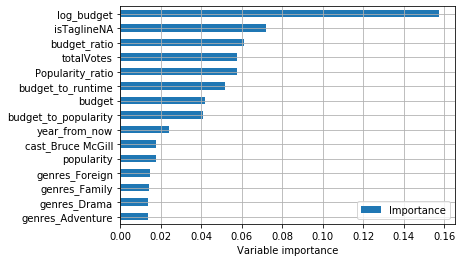

In [134]:
thresholds_XGB[:15].sort_values(by = 'Importance').plot(kind = 'barh')
plt.xlabel('Variable importance')
plt.grid()

In [135]:
## see if overfitting
Y_pred = movie_best_XGB.predict(X_train)
mean_squared_error(Y_train,Y_pred)**(1/2)

1.6067121115877092

In [136]:
# test = test[chosen_features]
Act_test_pred = movie_best_XGB.predict(test)

Actual_test = np.expm1(Act_test_pred)

test_id = pd.read_csv('test.csv')

submission = pd.DataFrame({'id':test_id.id,'revenue':Actual_test})

submission.to_csv('submission_XGB.csv',index=False)

In [ ]:
### The rmlse for the test dataset calculated by Kaggle is 2.40936

### 3.2.2 lgb

In [137]:
def remove_nonAscii(df):
    c = df.columns
    def removeNonAscii(s): return "".join(i for i in s if ord(i)<128)
    c = [removeNonAscii(i) for i in c]
    df.columns = c
    return df

X_train = remove_nonAscii(X_train)
X_test = remove_nonAscii(X_test)
test = remove_nonAscii(test)

In [138]:
### feature selection with variable importance
import lightgbm as lgb
param_grid = {'num_leaves': [10,20,30],
             'min_data_in_leaf': [20, 80, 200],
             'max_depth': [2,3,4,5],   
             'learning_rate': [0.01],
             "feature_fraction": [0.9],
             "bagging_freq": [1],
             "bagging_fraction": [0.9],
             "bagging_seed": [11],
             "lambda_l1": [0.2],
             "verbosity": [-1]}

movie_lgb = lgb.LGBMRegressor(n_estimators = 20000, nthread = 4, n_jobs = -1,objective ='regression',\
                             boosting="gbdt", metric='rmse')
grid_search = GridSearchCV(movie_lgb, param_grid, scoring='neg_mean_squared_error', cv=4, n_jobs = -1)
grid_result = grid_search.fit(X_train, Y_train)

print('best_params: ', grid_result.best_params_ , '\n'
      'best_score: ', grid_result.best_score_)

best_params:  {'bagging_fraction': 0.9, 'bagging_freq': 1, 'bagging_seed': 11, 'feature_fraction': 0.9, 'lambda_l1': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'min_data_in_leaf': 20, 'num_leaves': 30, 'verbosity': -1} 
best_score:  -3.678126756192255


In [139]:
## fit model using best_params
movie_lgb = lgb.LGBMRegressor(**grid_result.best_params_, n_estimators = 20000, nthread = 4, n_jobs = -1)
movie_lgb.fit(X_train, Y_train, 
        eval_set=[(X_train, Y_train), (X_test,Y_test)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[578]	training's rmse: 1.42343	training's l2: 2.02615	valid_1's rmse: 1.82548	valid_1's l2: 3.33239


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.9, importance_type='split', lambda_l1=0.2,
              learning_rate=0.01, max_depth=5, min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, verbosity=-1)

In [140]:
importance_lgb = movie_lgb.feature_importances_
## look into the importance of every feature
importances_lgb = pd.DataFrame({'Importance':importance_lgb},index = X.columns)
thresholds_lgb = importances_lgb.sort_values(by='Importance',axis = 0, ascending = False)
thresholds_lgb[:15]

,Importance
totalVotes,1368
year_from_now,727
budget_ratio,509
log_budget,508
budget_to_popularity,477
budget_to_runtime,455
rating,412
Popularity_ratio,376
budget,373
popularity,364


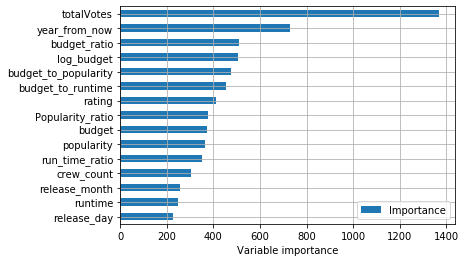

In [141]:
thresholds_lgb[:15].sort_values(by = 'Importance').plot(kind = 'barh')
plt.xlabel('Variable importance')
plt.grid()

In [142]:
## see if overfitting
Y_pred = movie_lgb.predict(X_train)
mean_squared_error(Y_train,Y_pred)**(1/2)

1.4234277410332663

In [143]:
## test error
Y_pred = movie_lgb.predict(X_test)
mean_squared_error(Y_test,Y_pred)**(1/2)

1.825484557693915

In [144]:
Act_test_pred = movie_lgb.predict(test)

Actual_test = np.expm1(Act_test_pred)

test_id = pd.read_csv('test.csv')

submission = pd.DataFrame({'id':test_id.id,'revenue':Actual_test})
submission.head()

submission.to_csv('submission_lgb.csv',index=False)

In [ ]:
### The rmlse for the test dataset calculated by Kaggle is 2.25182

### 3.2.3 CAT

In [145]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

In [146]:
## parameter tuning
param_grid = dict(depth=[5,6], learning_rate= [0.002, 0.05, 0.1],\
                  colsample_bylevel= [0.8], eval_metric=['RMSE'],bagging_temperature = [0.5])


movie_cat = CatBoostRegressor(metric_period = None, random_state=1,early_stopping_rounds=20)
grid_search = GridSearchCV(movie_cat, param_grid,scoring='neg_mean_squared_error', \
                           cv=3, n_jobs = -1)
grid_result = grid_search.fit(X_train, Y_train)

print('best_params: ', grid_result.best_params_ , '\n'
      'best_score: ', grid_result.best_score_)

0:	learn: 2.9592580	total: 55.5ms	remaining: 55.5s
1:	learn: 2.8905181	total: 58.2ms	remaining: 29s
2:	learn: 2.8233940	total: 60.4ms	remaining: 20.1s
3:	learn: 2.7628691	total: 63.3ms	remaining: 15.8s
4:	learn: 2.7084871	total: 65.6ms	remaining: 13s
5:	learn: 2.6585423	total: 69.3ms	remaining: 11.5s
6:	learn: 2.6103511	total: 71.5ms	remaining: 10.1s
7:	learn: 2.5674753	total: 73.8ms	remaining: 9.15s
8:	learn: 2.5271557	total: 75.9ms	remaining: 8.36s
9:	learn: 2.4827022	total: 78.1ms	remaining: 7.73s
10:	learn: 2.4410522	total: 80.2ms	remaining: 7.21s
11:	learn: 2.4077657	total: 82.2ms	remaining: 6.76s
12:	learn: 2.3735052	total: 84.2ms	remaining: 6.4s
13:	learn: 2.3408458	total: 86.4ms	remaining: 6.09s
14:	learn: 2.3101943	total: 88.5ms	remaining: 5.81s
15:	learn: 2.2829705	total: 90.5ms	remaining: 5.57s
16:	learn: 2.2539761	total: 92.6ms	remaining: 5.35s
17:	learn: 2.2305335	total: 94.6ms	remaining: 5.16s
18:	learn: 2.2107049	total: 96.5ms	remaining: 4.98s
19:	learn: 2.1924685	total:

177:	learn: 1.6299873	total: 631ms	remaining: 2.91s
178:	learn: 1.6271337	total: 635ms	remaining: 2.91s
179:	learn: 1.6268240	total: 639ms	remaining: 2.91s
180:	learn: 1.6244622	total: 643ms	remaining: 2.91s
181:	learn: 1.6241399	total: 648ms	remaining: 2.91s
182:	learn: 1.6222100	total: 653ms	remaining: 2.91s
183:	learn: 1.6208687	total: 657ms	remaining: 2.92s
184:	learn: 1.6205839	total: 662ms	remaining: 2.92s
185:	learn: 1.6179685	total: 667ms	remaining: 2.92s
186:	learn: 1.6171000	total: 672ms	remaining: 2.92s
187:	learn: 1.6157276	total: 677ms	remaining: 2.92s
188:	learn: 1.6155376	total: 681ms	remaining: 2.92s
189:	learn: 1.6153737	total: 686ms	remaining: 2.92s
190:	learn: 1.6150764	total: 691ms	remaining: 2.93s
191:	learn: 1.6142251	total: 695ms	remaining: 2.93s
192:	learn: 1.6137860	total: 699ms	remaining: 2.92s
193:	learn: 1.6120983	total: 702ms	remaining: 2.92s
194:	learn: 1.6111330	total: 706ms	remaining: 2.91s
195:	learn: 1.6093646	total: 710ms	remaining: 2.91s
196:	learn: 

367:	learn: 1.3894370	total: 1.2s	remaining: 2.07s
368:	learn: 1.3878126	total: 1.21s	remaining: 2.06s
369:	learn: 1.3877365	total: 1.21s	remaining: 2.06s
370:	learn: 1.3862692	total: 1.21s	remaining: 2.06s
371:	learn: 1.3860987	total: 1.22s	remaining: 2.06s
372:	learn: 1.3849415	total: 1.22s	remaining: 2.05s
373:	learn: 1.3832591	total: 1.22s	remaining: 2.05s
374:	learn: 1.3819945	total: 1.23s	remaining: 2.04s
375:	learn: 1.3813050	total: 1.23s	remaining: 2.04s
376:	learn: 1.3801112	total: 1.23s	remaining: 2.04s
377:	learn: 1.3790739	total: 1.23s	remaining: 2.03s
378:	learn: 1.3778827	total: 1.24s	remaining: 2.02s
379:	learn: 1.3771672	total: 1.24s	remaining: 2.02s
380:	learn: 1.3768471	total: 1.24s	remaining: 2.01s
381:	learn: 1.3759212	total: 1.24s	remaining: 2.01s
382:	learn: 1.3739095	total: 1.24s	remaining: 2s
383:	learn: 1.3728157	total: 1.25s	remaining: 2s
384:	learn: 1.3708777	total: 1.25s	remaining: 1.99s
385:	learn: 1.3696063	total: 1.25s	remaining: 1.99s
386:	learn: 1.36850

530:	learn: 1.2364503	total: 1.58s	remaining: 1.4s
531:	learn: 1.2355958	total: 1.58s	remaining: 1.39s
532:	learn: 1.2349154	total: 1.59s	remaining: 1.39s
533:	learn: 1.2334953	total: 1.59s	remaining: 1.39s
534:	learn: 1.2325231	total: 1.59s	remaining: 1.39s
535:	learn: 1.2314752	total: 1.6s	remaining: 1.38s
536:	learn: 1.2311077	total: 1.6s	remaining: 1.38s
537:	learn: 1.2309038	total: 1.6s	remaining: 1.38s
538:	learn: 1.2301361	total: 1.61s	remaining: 1.37s
539:	learn: 1.2289724	total: 1.61s	remaining: 1.37s
540:	learn: 1.2281569	total: 1.61s	remaining: 1.37s
541:	learn: 1.2270618	total: 1.61s	remaining: 1.36s
542:	learn: 1.2263339	total: 1.61s	remaining: 1.36s
543:	learn: 1.2257889	total: 1.62s	remaining: 1.36s
544:	learn: 1.2252708	total: 1.62s	remaining: 1.35s
545:	learn: 1.2244280	total: 1.62s	remaining: 1.35s
546:	learn: 1.2232960	total: 1.63s	remaining: 1.35s
547:	learn: 1.2214396	total: 1.63s	remaining: 1.34s
548:	learn: 1.2202200	total: 1.63s	remaining: 1.34s
549:	learn: 1.21

737:	learn: 1.0766001	total: 2.15s	remaining: 762ms
738:	learn: 1.0764104	total: 2.15s	remaining: 759ms
739:	learn: 1.0758181	total: 2.15s	remaining: 757ms
740:	learn: 1.0756306	total: 2.16s	remaining: 754ms
741:	learn: 1.0746666	total: 2.16s	remaining: 751ms
742:	learn: 1.0744447	total: 2.16s	remaining: 748ms
743:	learn: 1.0738633	total: 2.17s	remaining: 745ms
744:	learn: 1.0738112	total: 2.17s	remaining: 743ms
745:	learn: 1.0731650	total: 2.17s	remaining: 740ms
746:	learn: 1.0719365	total: 2.18s	remaining: 737ms
747:	learn: 1.0717617	total: 2.18s	remaining: 734ms
748:	learn: 1.0707410	total: 2.18s	remaining: 731ms
749:	learn: 1.0700044	total: 2.18s	remaining: 728ms
750:	learn: 1.0699545	total: 2.19s	remaining: 725ms
751:	learn: 1.0697160	total: 2.19s	remaining: 721ms
752:	learn: 1.0694992	total: 2.19s	remaining: 718ms
753:	learn: 1.0694568	total: 2.19s	remaining: 715ms
754:	learn: 1.0682987	total: 2.19s	remaining: 712ms
755:	learn: 1.0676681	total: 2.19s	remaining: 709ms
756:	learn: 

979:	learn: 0.9430904	total: 2.71s	remaining: 55.4ms
980:	learn: 0.9423387	total: 2.72s	remaining: 52.6ms
981:	learn: 0.9414693	total: 2.72s	remaining: 49.9ms
982:	learn: 0.9406794	total: 2.73s	remaining: 47.1ms
983:	learn: 0.9400744	total: 2.73s	remaining: 44.4ms
984:	learn: 0.9398636	total: 2.73s	remaining: 41.6ms
985:	learn: 0.9391652	total: 2.74s	remaining: 38.9ms
986:	learn: 0.9386270	total: 2.74s	remaining: 36.1ms
987:	learn: 0.9375520	total: 2.74s	remaining: 33.3ms
988:	learn: 0.9366734	total: 2.74s	remaining: 30.5ms
989:	learn: 0.9359793	total: 2.75s	remaining: 27.7ms
990:	learn: 0.9355733	total: 2.75s	remaining: 25ms
991:	learn: 0.9354359	total: 2.75s	remaining: 22.2ms
992:	learn: 0.9347639	total: 2.75s	remaining: 19.4ms
993:	learn: 0.9343170	total: 2.75s	remaining: 16.6ms
994:	learn: 0.9337531	total: 2.76s	remaining: 13.9ms
995:	learn: 0.9334130	total: 2.76s	remaining: 11.1ms
996:	learn: 0.9329286	total: 2.76s	remaining: 8.31ms
997:	learn: 0.9323781	total: 2.76s	remaining: 5.

In [147]:
## fit model using best_params
eval_set = [(X_test,Y_test)]
movie_best_cat = CatBoostRegressor(**grid_search.best_params_,random_state=1)
movie_best_cat.fit(X_train,Y_train, early_stopping_rounds = 200,
         eval_set = eval_set,verbose = False)

## predict
Y_pred = movie_best_cat.predict(X_test)
mean_squared_error(Y_test,Y_pred)**(1/2)

1.8309227863554445

In [148]:
importance_cat = movie_best_cat.feature_importances_
## look into the importance of every feature
importances_cat = pd.DataFrame({'Importance':importance_cat},index = X.columns)
thresholds_cat = importances_cat.sort_values(by='Importance',axis = 0, ascending = False)
thresholds_cat[:15]

,Importance
log_budget,20.293348
totalVotes,12.516591
budget,8.069137
year_from_now,5.388846
Popularity_ratio,5.343801
budget_to_runtime,5.044161
budget_to_popularity,4.525024
popularity,2.846729
budget_ratio,2.668545
rating,2.566871


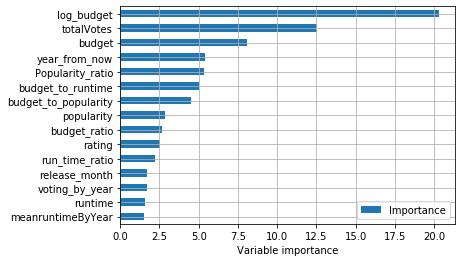

In [149]:
thresholds_cat[:15].sort_values(by = 'Importance').plot(kind = 'barh')
plt.xlabel('Variable importance')
plt.grid()

In [150]:
test.shape

(4398, 139)

In [159]:
Act_test_pred = movie_best_cat.predict(test)
Actual_test = np.expm1(Act_test_pred)

test_id = pd.read_csv('test.csv')

submission = pd.DataFrame({'id':test_id.id,'revenue':Actual_test})
submission.head()

submission.to_csv('submission_cat.csv',index=False)

In [ ]:
### The rmlse for the test dataset calculated by Kaggle is 2.17823

### 3.2.4 Ensemble of three models

In [ ]:
## since CAT has better prediction, give CAT more weight in the ensemble

In [158]:
submission_lgb = pd.read_csv('submission_lgb.csv')
submission_cat = pd.read_csv('submission_cat.csv')
submission_XGB = pd.read_csv('submission_XGB.csv')

result = 0.3*submission_lgb['revenue'] + 0.4*submission_cat['revenue'] + 0.3*submission_XGB['revenue']
submission_XGB['revenue'] = result
result_DF = submission_XGB

result_DF.to_csv('result_DF.csv',index=False)

In [ ]:
### The rmlse for the test dataset calculated by Kaggle is 2.17823